In [71]:
import numpy as np
import pathlib
import importlib
import matplotlib.pyplot as plt
import glob
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


RECON_PATH = pathlib.Path("../data/20241011_phantom_mono/run2/prostate/reconstruction/droid")
# RECON_PATH = pathlib.Path("/home/fj/Projects/ARPA-H/cur_vslam_models/DROID-SLAM/reconstructions/abandonedfactory")


In [72]:
disps = np.load((RECON_PATH/"disps.npy").resolve())
images = np.load((RECON_PATH/"images.npy").resolve())
intrinsics = np.load((RECON_PATH/"intrinsics.npy").resolve())
poses = np.load((RECON_PATH/"poses.npy").resolve())
tstamps = np.load((RECON_PATH/"tstamps.npy").resolve())

print(disps.shape)
print(images.shape)
print(intrinsics)
print(poses.shape)
print(tstamps.shape)

depth = 1 / disps
depth[depth > 20] = 20

(190, 328, 584)
(190, 3, 328, 584)
[[30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.949413 37.917236 22.369852]
 [30.92539  30.9494

In [73]:
poses[5, :]

array([-0.02562965,  0.01350053,  0.04856056, -0.03327104, -0.02797406,
        0.00830748,  0.9990212 ], dtype=float32)

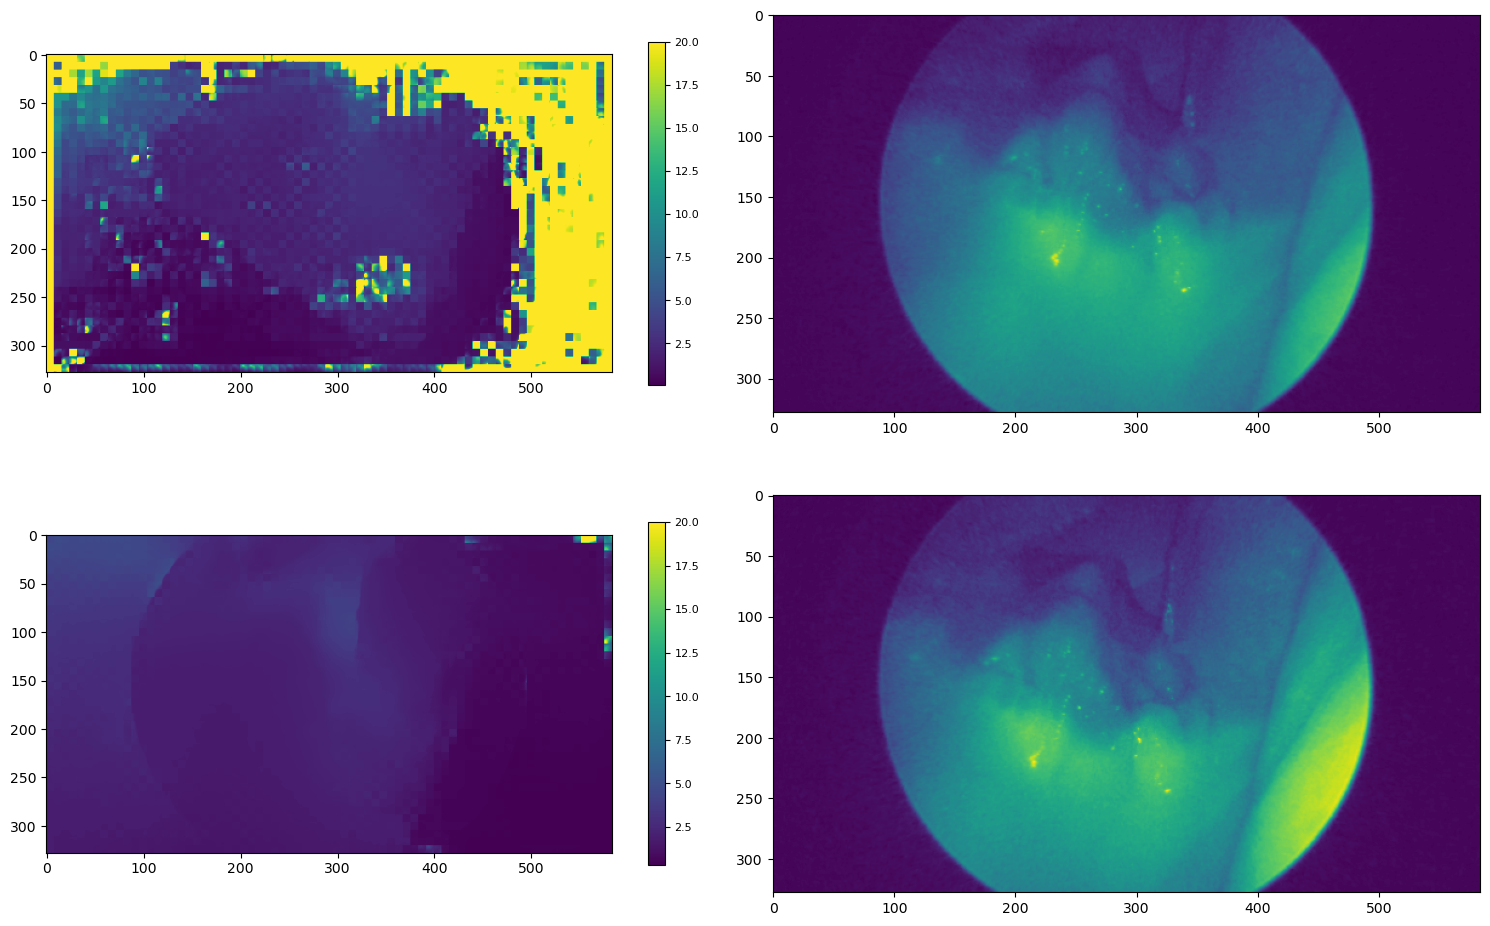

In [74]:
# Set up the figure with 2 rows and 3 columns
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

# First row, first image with color bar
plt.subplot(2, 2, 1)
plt.imshow(depth[0, :, :])
cbar = plt.colorbar(shrink=0.7)  # Shrink color bar to 70% of the default size
cbar.ax.tick_params(labelsize=8)  # Make color bar labels smaller

# First row, second image without color bar
plt.subplot(2, 2, 2)
plt.imshow(images[0, 0, :, :])

# Second row, first image with color bar
plt.subplot(2, 2, 3)
plt.imshow(depth[5, :, :])
cbar = plt.colorbar(shrink=0.7)  # Color bar for the second row
cbar.ax.tick_params(labelsize=8)  # Adjust label size for uniformity

# Second row, second image without color bar
plt.subplot(2, 2, 4)
plt.imshow(images[5, 0, :, :])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


In [77]:

class CameraPose:
    def __init__(self, meta, mat):
        self.metadata = meta
        self.pose = mat

    def __str__(self):
        return (
            "Metadata : "
            + " ".join(map(str, self.metadata))
            + "\n"
            + "Pose : "
            + "\n"
            + np.array_str(self.pose)
        )


def read_trajectory(filename):
    traj = []
    with open(filename, "r", encoding="utf-8") as f:
        metastr = f.readline()
        while metastr:
            metadata = list(map(int, metastr.split()))
            mat = np.zeros(shape=(4, 4))
            for i in range(4):
                matstr = f.readline()
                mat[i, :] = np.fromstring(matstr, dtype=float, sep=" \t")
            traj.append(CameraPose(metadata, mat))
            metastr = f.readline()
    return traj


volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=25.0 / 512.0,
    sdf_trunc=0.1,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8,
)

intrinsics = np.load(RECON_PATH/"intrinsics.npy")

fx = intrinsics[0][0]
fy = intrinsics[0][1]
cx = intrinsics[0][2]
cy = intrinsics[0][3]
fx, fy, cx, cy = 267.91539663, 268.47683254, 328.48771906, 194.05173664

color_images = np.load(RECON_PATH/"images.npy")
depth_images = 1/np.load(RECON_PATH/"disps.npy")
depth_images[depth_images > 100] = 100
camera_poses =  np.load(RECON_PATH/"poses.npy") # read_trajectory(RECON_PATH/"log.txt")
camera_poses_mat = []
for i in range(camera_poses.shape[0]):
    cur_rot = R.from_quat(camera_poses[i, 3:])
    cur_pose_mat = np.eye(4)
    cur_pose_mat[:3, :3] = cur_rot.as_matrix()
    cur_pose_mat[:3, 3] = camera_poses[i, :3]

    camera_poses_mat.append(cur_pose_mat)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=584, height=328, fx=fx, fy=fy, cx=cx, cy=cy
    # width=512, height=384, fx=fx, fy=fy, cx=cx, cy=cy
)

for i in range(len(color_images)):
    print(f"Integrate {i}-th image into the volume.")
    color = color_images[i]
    color = np.ascontiguousarray(color.transpose(1, 2, 0))
    color = o3d.geometry.Image((color).astype(np.uint8))
    depth = depth_images[i]
    depth = np.ascontiguousarray(depth.transpose(0, 1))
    depth = o3d.geometry.Image((depth * 255))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False
    )

    volume.integrate(rgbd, camera_intrinsic, np.linalg.inv(camera_poses_mat[i]))

print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
point_cloud = mesh.sample_points_uniformly(number_of_points=100000)     
o3d.visualization.draw_geometries([mesh])


Integrate 0-th image into the volume.
Integrate 1-th image into the volume.
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.
Integrate 5-th image into the volume.
Integrate 6-th image into the volume.
Integrate 7-th image into the volume.
Integrate 8-th image into the volume.
Integrate 9-th image into the volume.
Integrate 10-th image into the volume.
Integrate 11-th image into the volume.
Integrate 12-th image into the volume.
Integrate 13-th image into the volume.
Integrate 14-th image into the volume.
Integrate 15-th image into the volume.
Integrate 16-th image into the volume.
Integrate 17-th image into the volume.
Integrate 18-th image into the volume.
Integrate 19-th image into the volume.
Integrate 20-th image into the volume.
Integrate 21-th image into the volume.
Integrate 22-th image into the volume.
Integrate 23-th image into the volume.
Integrate 24-th image into the volume.
Integrate 25-th image into the volu

In [13]:
camera_poses[1, :]

array([-1.3586936e-02, -9.1758287e-03,  2.2815995e-02,  7.3306559e-04,
       -1.1692189e-02, -8.4070303e-03,  9.9989790e-01], dtype=float32)